In [ ]:
# Cell 1: Mount Drive & Import Libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import pandas as pd
from google.colab import drive

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Base dataset directory
DATA_DIR = '/content/drive/MyDrive/Dataset/Datasets'

# 3️⃣ Classes to include
classes = ['honeycombing', 'void', 'no_defect']

# 4️⃣ Gather image paths and labels
data = []
for cls in classes:
    class_dir = os.path.join(DATA_DIR, cls)
    if not os.path.exists(class_dir):
        print(f"Warning: folder '{cls}' not found at {class_dir}")
        continue
    for filename in os.listdir(class_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            filepath = os.path.join(class_dir, filename)
            data.append({'filepath': filepath, 'label': cls})

# 5️⃣ Create dataframe
df = pd.DataFrame(data)

# 6️⃣ Shuffle for randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 7️⃣ Display summary
print(df.head())
print(f"\nTotal images: {len(df)}")
print(df['label'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            filepath         label
0  /content/drive/MyDrive/Dataset/Datasets/no_def...     no_defect
1  /content/drive/MyDrive/Dataset/Datasets/no_def...     no_defect
2  /content/drive/MyDrive/Dataset/Datasets/honeyc...  honeycombing
3  /content/drive/MyDrive/Dataset/Datasets/honeyc...  honeycombing
4  /content/drive/MyDrive/Dataset/Datasets/void/i...          void

Total images: 4069
label
honeycombing    2368
no_defect       1183
void             518
Name: count, dtype: int64


In [ ]:
# Find the size of the smallest class to use as the target sample size
min_count = df['label'].value_counts().min()
print(f"\nBalancing classes to {min_count} images each...")

# Create a new, balanced DataFrame by sampling from each class
df_balanced = pd.concat([
    df[df['label'] == label].sample(min_count, random_state=42)
    for label in df['label'].unique()
])

# Replace the old DataFrame with the balanced one and shuffle it
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nNew Balanced Class Distribution:")
print(df['label'].value_counts())
print(f"\nTotal images in balanced dataset: {len(df)}")


Balancing classes to 518 images each...

New Balanced Class Distribution:
label
void            518
no_defect       518
honeycombing    518
Name: count, dtype: int64

Total images in balanced dataset: 1554


In [ ]:
# Cell 3: Create High-Performance (and HANG-PROOF) tf.data Pipelines
import tensorflow as tf
from tensorflow.keras.utils import get_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from PIL import Image

# --- GPU Optimizations ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 128 # You can lower this to 64 if you get memory errors
# -------------------------

# Encode labels (from Cell 2)
encoder = LabelEncoder()
df['label_encoded'] = encoder.fit_transform(df['label'])

# Split the DataFrame
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")
print(f"Classes: {encoder.classes_}")

# --- Robust PIL-based loader ---
AUTOTUNE = tf.data.AUTOTUNE

def _load_image_pil_py(filepath):
    filepath_str = filepath.numpy().decode('utf-8')
    img = Image.open(filepath_str).convert('RGB').resize(IMG_SIZE)
    img_array = np.array(img, dtype=np.float32)
    return img_array

def load_image_wrapper(filepath, label):
    [image,] = tf.py_function(_load_image_pil_py, [filepath], [tf.float32])
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    return image, label

# --- MODIFIED: configure_dataset ---
# We have REMOVED dataset.cache() to prevent the hang.
def configure_dataset(dataset, shuffle=False):
    # dataset = dataset.cache() # <-- REMOVED THIS LINE
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

# --- Create the Datasets ---
print("\nCreating tf.data.Dataset objects (without caching)...")

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['filepath'].values, train_df['label_encoded'].values)
)
# MODIFIED: Removed num_parallel_calls for stability
train_ds = train_ds.map(load_image_wrapper)
train_ds = configure_dataset(train_ds, shuffle=True)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['filepath'].values, val_df['label_encoded'].values)
)
# MODIFIED: Removed num_parallel_calls for stability
val_ds = val_ds.map(load_image_wrapper)
val_ds = configure_dataset(val_ds, shuffle=False)

print("Data pipelines created successfully.")

# --- Sanity Check ---
print("\nPerforming sanity check: pulling one batch...")
try:
    for images, labels in train_ds.take(1):
        print(f"Success! Batch shape: {images.shape}")
        print(f"Labels shape: {labels.shape}")
except Exception as e:
    print(f"\nCaught an error during sanity check! This is the problem:")
    print(e)
    print("\nPlease check the error message.")

Training samples: 1243, Validation samples: 311
Classes: ['honeycombing' 'no_defect' 'void']

Creating tf.data.Dataset objects (without caching)...
Data pipelines created successfully.

Performing sanity check: pulling one batch...
Success! Batch shape: (128, 224, 224, 3)
Labels shape: (128,)


In [ ]:
# Cell 4: Build the 3-Class Transfer Learning Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Data Augmentation layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name="data_augmentation")

# Load the Pre-trained Base Model
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# FREEZE the Base Model
base_model.trainable = False

# Build Our New Model
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x) # Apply MobileNetV2's specific normalization
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# --- MODIFIED: Output layer for 3 classes ---
# Use 3 units (one for each class) and 'softmax' activation
outputs = Dense(3, activation='softmax')(x)
# ---------------------------------------------

model = Model(inputs, outputs)

# --- MODIFIED: Compile for 3 classes ---
# Use 'sparse_categorical_crossentropy' for multi-class classification
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# ---------------------------------------------

model.summary()

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [ ]:
# Cell 5: Train the Model (Stage 1 Only)

print("\n--- Starting Training (Stage 1: Feature Extraction) ---")
EPOCHS = 30 # EarlyStopping will find the best epoch

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping] # Stop when val_loss stops improving
)

print("\n--- Training Complete! ---")


--- Starting Training (Stage 1: Feature Extraction) ---
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 111s 10s/step - accuracy: 0.6658 - loss: 0.9184 - val_accuracy: 0.9100 - val_loss: 0.1977
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 600ms/step - accuracy: 0.9469 - loss: 0.1888 - val_accuracy: 0.9518 - val_loss: 0.1025
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 548ms/step - accuracy: 0.9481 - loss: 0.1409 - val_accuracy: 0.9775 - val_loss: 0.0693
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 577ms/step - accuracy: 0.9660 - loss: 0.1048 - val_accuracy: 0.9871 - val_loss: 0.0621
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 512ms/step - accuracy: 0.9629 - loss: 0.1177 - val_accuracy: 0.9839 - val_loss: 0.0566
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 509ms/step - accuracy: 0.9790 - loss: 0.0736 - val_accuracy: 0.9839 - val_loss: 0.0525
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 514ms/step - accuracy: 0.9746 - loss: 0.0610 - val_accuracy: 0.9807 - val_loss: 0.0504
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s

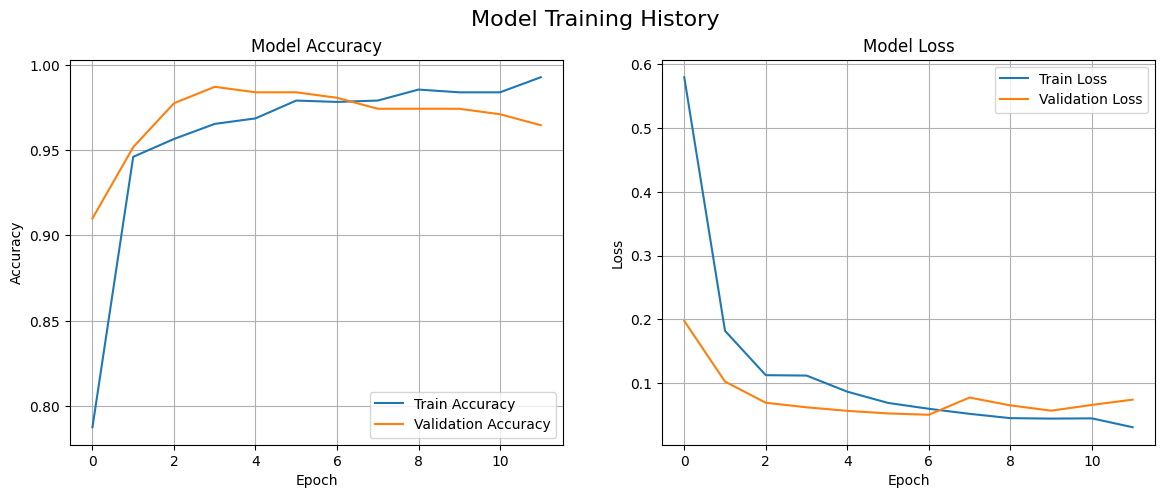


Evaluating model on the validation dataset...
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 778ms/step - accuracy: 0.9786 - loss: 0.0541
Validation Loss: 0.0504
Validation Accuracy: 0.9807

Generating Confusion Matrix and Classification Report...
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 713ms/step


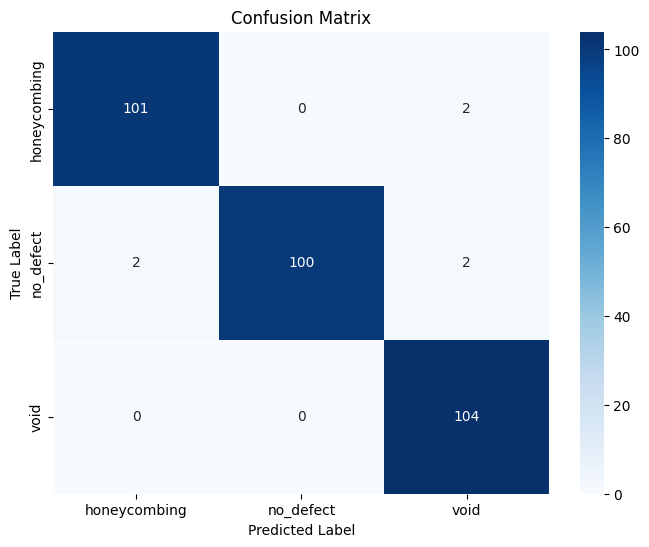


Classification Report:
              precision    recall  f1-score   support

honeycombing       0.98      0.98      0.98       103
   no_defect       1.00      0.96      0.98       104
        void       0.96      1.00      0.98       104

    accuracy                           0.98       311
   macro avg       0.98      0.98      0.98       311
weighted avg       0.98      0.98      0.98       311



In [ ]:
# Cell 6: Visualize Results and Evaluate

# --- 1. Plot Training History ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Training History', fontsize=16)

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')
ax2.grid(True)
plt.show()

# --- 2. Evaluate on Validation Set ---
print("\nEvaluating model on the validation dataset...")
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# --- 3. Confusion Matrix & Classification Report ---
print("\nGenerating Confusion Matrix and Classification Report...")

# Get predictions for the entire validation set
y_pred_probs = model.predict(val_ds)
# --- MODIFIED: Use np.argmax for 3 classes ---
# Find the index (0, 1, or 2) with the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)
# ---------------------------------------------

# Get the true labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Create the 3x3 confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 4. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

In [ ]:
# Cell 7: Save the Trained 3-Class Model

print("Saving the 3-class model to Google Drive...")

# Define a new file path for this specific model
# We'll call it 'concrete_3_class_model_v1.keras'
model_save_path = '/content/drive/My Drive/changes02_3_class_model_v1.keras'

try:
    model.save(model_save_path)
    print(f"\nModel saved successfully!")
    print(f"Path: {model_save_path}")
except Exception as e:
    print(f"\nAn error occurred while saving the model: {e}")

Saving the 3-class model to Google Drive...

Model saved successfully!
Path: /content/drive/My Drive/changes02_3_class_model_v1.keras
